In [108]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

import json

%cd /data/lyna/Milestone_Error_Analysis_Testing/milestone-debug
import analysis_functions

/data/lyna/Milestone_Error_Analysis_Testing/milestone-debug


# First, let's test a small symmetric potential with brute-force BD

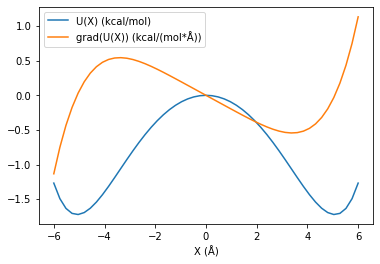

In [3]:
# a*x^6-b*x^2 has minima in x =+-1 and a barrier at x=0
# The ratio a/b can must be tuned depending on the kT used in the brownian dynamics, so that the barrier can be crossed repeatedly.

def potFun(x):
    return(0.1*((1/2000)*(x)**6-(x)**2))
def potGradFun(x):
    return(0.1*((6.0/2000)*(x)**5-2.0*(x)))

xgrid=np.linspace(-6,6,51)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)


sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)


plt.xlabel('X (Å)')
#plt.ylim(-0.5,0.5)
plt.show()

In [110]:
#Air(g)-water(g) diffusion constant: .282 cm**2/s (at 25 ºC)
# -> (10**-8)**2/10**-15 = 10**-1 Å**2/fs per cm**2/s
# so Air-water = .0282 Å**2/fs
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

bd_Sim=analysis_functions.Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=10,
    verbose=True,
    timestep=2.0
))
bd_Sim.set_x0(-6.)
print(bd_Sim.parameter_dict)
print(np.linspace(-6,6,25))


{'diffusionConstant': 0.02933499916149589, 'temperature': 310.15, 'vmax': 15.0, 'trajectorySnapshotRate': 10, 'periodicBoundaryLength': None, 'timestep': 2.0, 'verbose': True}
[-6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5
  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6. ]


In [8]:
nsteps=2000000 #2000k steps = 4 us
trajData=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))
print("Done")

/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


2000000
Done



kbT 0.6159191312499999
binCenters [-5.94285714 -5.82857143 -5.71428571 -5.6        -5.48571429 -5.37142857
 -5.25714286 -5.14285714 -5.02857143 -4.91428571 -4.8        -4.68571429
 -4.57142857 -4.45714286 -4.34285714 -4.22857143 -4.11428571 -4.
 -3.88571429 -3.77142857 -3.65714286 -3.54285714 -3.42857143 -3.31428571
 -3.2        -3.08571429 -2.97142857 -2.85714286 -2.74285714 -2.62857143
 -2.51428571 -2.4        -2.28571429 -2.17142857 -2.05714286 -1.94285714
 -1.82857143 -1.71428571 -1.6        -1.48571429 -1.37142857 -1.25714286
 -1.14285714 -1.02857143 -0.91428571 -0.8        -0.68571429 -0.57142857
 -0.45714286 -0.34285714 -0.22857143 -0.11428571  0.          0.11428571
  0.22857143  0.34285714  0.45714286  0.57142857  0.68571429  0.8
  0.91428571  1.02857143  1.14285714  1.25714286  1.37142857  1.48571429
  1.6         1.71428571  1.82857143  1.94285714  2.05714286  2.17142857
  2.28571429  2.4         2.51428571  2.62857143  2.74285714  2.85714286
  2.97142857  3.08571429  3.2  

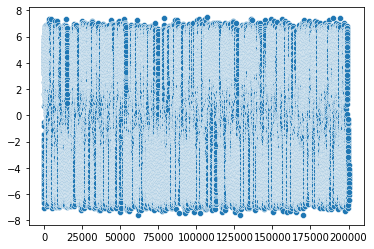

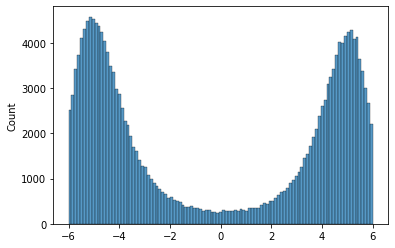

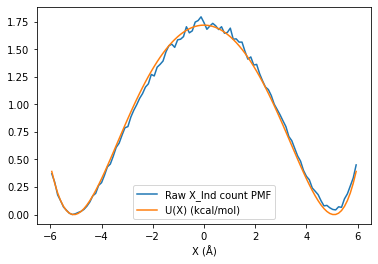

In [9]:
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
print("kbT",kbT, )

binEdges=np.linspace(-6,6,106)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binCenters",binCenters)
xgrid=binCenters

sim_pmf_hist=np.histogram(
    a=trajData['trajectory'],
    bins=binEdges
)
#display(sim_pmf_hist)

sns.scatterplot(x=np.arange(0, len(trajData['trajectory'])), y=trajData['trajectory'])
plt.show()
sns.histplot(trajData['trajectory'],bins=binEdges)
plt.show()


sim_pmf_vec=sim_pmf_hist[0]
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec) # normalize histogram
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.max(sim_pmf_vec))

sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)

plt.xlabel('X (Å)')
plt.show()

# Test brute-force BD with different timesteps

# Test brute-force BD with different diffusion constants

# Now setup milestoning

In [111]:
# flatbottom potential for milestoning
def gen_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potFun(x)+.5*kval * ( (x<win_lhs)*(win_lhs-x)**2 + (x>win_rhs)*(win_rhs-x)**2 )
    )
def gen_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potGradFun(x)-kval * ( (x<win_lhs)*(win_lhs-x) + (x>win_rhs)*(win_rhs-x) )
    )

symm_window_edges=np.linspace(-6.,6.,25)
symm_window_lhs=symm_window_edges[:-1]
symm_window_rhs=symm_window_edges[1:]
symm_window_centers=(symm_window_lhs+symm_window_rhs)/2.
symm_window_kVals=np.array([100.]*len(symm_window_centers)) # force constant kVal=1
print(symm_window_lhs,symm_window_centers, symm_window_rhs, symm_window_kVals)

symm_window_potFuns=[
    gen_flat_bottom_harmonic_window_potFun(potFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]

symm_window_potGradFuns=[
    gen_flat_bottom_harmonic_window_potGradFun(potGradFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]


winNum=np.arange(0,len(symm_window_centers))
print(winNum)

[-6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5
  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5] [-5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25
  0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75] [-5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.
  1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6. ] [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


win 0
win 1
win 2
win 3
win 4
win 5
win 6
win 7
win 8
win 9
win 10
win 11
win 12
win 13
win 14
win 15
win 16
win 17
win 18
win 19
win 20
win 21
win 22
win 23


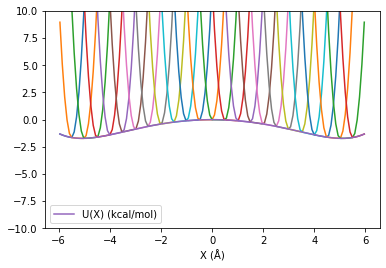

In [112]:
# plot milestone potential

winPot=[]
winPotGrad=[]
for win in winNum:
    print("win",win)
    winPot=symm_window_potFuns[win]
    winPotGrad=symm_window_potGradFuns[win]
    
    binEdges=np.linspace(-6,6,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters

    sns.lineplot(
        x=xgrid,
        y=winPot(xgrid),
        #label='symm_win_%02g_U(x)'%win
    )
    
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)

plt.xlabel('X (Å)')
plt.ylim(-10,10)
plt.show()

kbT 0.6159191312499999
symm_window_centers [-5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25
  0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75]


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


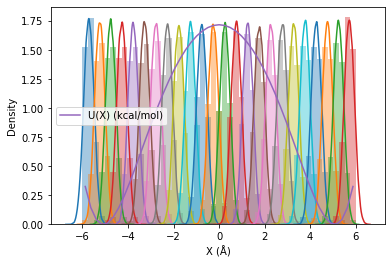

In [113]:
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
print("kbT",kbT, )
print("symm_window_centers",symm_window_centers)

symm_win_sim_data=[]
for iWin,winCenter in enumerate(symm_window_centers):
    win_potGradFun=symm_window_potGradFuns[iWin]
    bd_Sim=analysis_functions.Simple_1D_BD_Sim(win_potGradFun)
    bd_Sim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=10,
        verbose=True,
        timestep=0.5
    ))
    bd_Sim.set_x0(winCenter)

    nsteps=500000 #500k steps x24 windows x 0.5 fs= 6 us, sufficeint to converge brute-force BD
    symm_win_sim_data.append(bd_Sim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps)))

    trajData=symm_win_sim_data[iWin]
    binEdges=np.linspace(-6,6,50)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters
    sim_pmf_hist=np.histogram(
        a=trajData['trajectory'],
        bins=binEdges
    )
    #display(sim_pmf_hist)
    sim_pmf_vec=sim_pmf_hist[0]
    sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
    #sim_pmf_vec=-kbT*np.log(sim_pmf_vec)
    #sim_pmf_mask=np.where(np.isfinite(sim_pmf_vec))
    #sim_pmf_vec=sim_pmf_vec-np.min(
    #    sim_pmf_vec[sim_pmf_mask]
    #)
    #sns.scatterplot(
    #    x=xgrid[sim_pmf_mask],
    #    y=sim_pmf_vec[sim_pmf_mask],
    #    #label='Raw X_Ind count PMF'
    #)
    sns.distplot(trajData['trajectory'],bins=binEdges, color=None)
    

xgrid=binCenters  #np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)

plt.xlabel('X (Å)')
plt.show()

In [116]:
for iWin,winCenter in enumerate(symm_window_centers):
    print(iWin, winCenter)

0 -5.75
1 -5.25
2 -4.75
3 -4.25
4 -3.75
5 -3.25
6 -2.75
7 -2.25
8 -1.75
9 -1.25
10 -0.75
11 -0.25
12 0.25
13 0.75
14 1.25
15 1.75
16 2.25
17 2.75
18 3.25
19 3.75
20 4.25
21 4.75
22 5.25
23 5.75


In [117]:
for iWin,winData in enumerate(symm_win_sim_data):
    stepsPerWindow=(len(winData['trajectory']))
print(stepsPerWindow)

50000


In [125]:
milestone_data_table=pd.DataFrame({
    'Window':(np.array([[iWin]*len(winData['trajectory']) for iWin,winData in enumerate(symm_win_sim_data)])).flatten(),
    'X':(np.array([winData['trajectory'] for winData in symm_win_sim_data])).flatten(),
    "WindowCenter":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])).flatten()),
    #"WindowLeft":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])-1.5).flatten()),
    #"WindowRight":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])+1.5).flatten()),
})
milestone_data_table['X_Ind']=milestone_data_table['X'].map(lambda x: np.argmin(np.abs(x-symm_window_centers)))
milestone_data_table
milestone_data_table.to_csv('data_window.csv',index=False)

In [126]:
symm_window_data=pd.DataFrame({
    'Window':np.arange(len(symm_window_centers)),
    'LHS_Edge':symm_window_lhs,
    'Center':symm_window_centers,
    'RHS_Edge':symm_window_rhs
})
print('saving window setup data')
display(symm_window_data.head())
symm_window_data.to_csv('setup_windows.csv',index=False)
import json
#print('saving simulation parameter setup')
#display(bd_Sim.parameter_dict)
#with open('setup_4window.json', 'w') as fp:
#    json.dump(bd_Sim.parameter_dict, fp)

saving window setup data


,Window,LHS_Edge,Center,RHS_Edge
0,0,-6.0,-5.75,-5.5
1,1,-5.5,-5.25,-5.0
2,2,-5.0,-4.75,-4.5
3,3,-4.5,-4.25,-4.0
4,4,-4.0,-3.75,-3.5


# Analyze milestoning BD results

In [120]:
# add a frame column for each window
milestoneSimulationsData=milestone_data_table
print(milestoneSimulationsData.head())

tempFrames=[]
with tqdm.tqdm_notebook(milestoneSimulationsData.groupby(['Window'])) as pbar:
    for group in pbar:
        groupName,groupData=group
        tempFrame=groupData.copy()
        tempFrame['Frame']=np.arange(len(tempFrame))
        tempFrame['Replica']=0
        tempFrame=tempFrame[['Replica','Window','Frame','X','X_Ind']]
        tempFrames.append(tempFrame.copy())
        gc.collect()
milestoneSimulationsData=pd.concat(tempFrames)
milestoneSimulationsData

   Window         X  WindowCenter  X_Ind
0       0 -5.750000         -5.75      0
1       0 -6.102925         -5.75      0
2       0 -5.901807         -5.75      0
3       0 -5.758886         -5.75      0
4       0 -6.144362         -5.75      0


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,Replica,Window,Frame,X,X_Ind
0,0,0,0,-5.750000,0
1,0,0,1,-6.102925,0
2,0,0,2,-5.901807,0
3,0,0,3,-5.758886,0
4,0,0,4,-6.144362,0
...,...,...,...,...,...
1199995,0,23,49995,5.876828,23
1199996,0,23,49996,5.835927,23
1199997,0,23,49997,6.370140,23
1199998,0,23,49998,5.957369,23


In [121]:
milestoneData=analysis_functions.add_indexed_milestoning_analysis_columns(
    milestoneSimulationsData,
    windowColumn='Window',xIndexColumn='X_Ind',frameCol='Frame',
    repColumn=None,groupingColumn=None,verbose=True,
    verboseLevel=0
)
milestoneData["X"]=milestoneSimulationsData.X
milestoneData
milestoneData.to_csv("oneRep-Escape-Reentry.csv")

/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=0


--- --- --- Grouping Name: 0 --- --- ---
	--- --- Window Name: 0 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 11 --- ---
		--- Replica Name: 0 -

plt.figure(figsize=(42,3))
sns.lineplot(x=np.arange(0,len(milestoneSimulationsData['X'])),y=milestoneSimulationsData['X'],hue=milestoneSimulationsData['Window'])
plt.grid()
plt.show()
plt.figure(figsize=(42,3))
sns.lineplot(x=np.arange(0,len(milestoneSimulationsData['X'])),y=milestoneSimulationsData['X_Ind'],color='b',marker='o')
plt.show()
plt.figure(figsize=(42,3))
sns.lineplot(x=np.arange(0,len(milestoneSimulationsData['X'])),y=milestoneData['Escape_Vector'],color='g',marker='o')
#plt.show()
plt.figure(figsize=(42,3))
sns.lineplot(x=np.arange(0,len(milestoneSimulationsData['X'])),y=milestoneData['Reentry_Vector'],color='r',marker='o')
plt.show()

In [122]:
#################### pi_vector and PMF ################

kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

analysisFrame=milestoneData
binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Ind'].unique()
])))
print("binSet",binSet)

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
print('testEscapeData:',testEscapeData)

# escapeMat is the number of escape per frame, kij and kji, row sum must be 1



binSet [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
testEscapeData: {'piVec': array([0.06987055, 0.08880262, 0.08748614, 0.07114459, 0.05225622,
       0.03904962, 0.02866285, 0.02103781, 0.01664765, 0.01398819,
       0.01224652, 0.01172945, 0.01146438, 0.01239795, 0.01396839,
       0.01615264, 0.02056794, 0.02799363, 0.03640171, 0.0504873 ,
       0.06554615, 0.08075403, 0.08449418, 0.06684948]), 'escapeMat': <24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 114 stored elements in List of Lists format>, 'counts': array([42055, 36853, 36895, 36699, 36428, 36654, 36538, 36417, 36470,
       36423, 36339, 36608, 36445, 36626, 36580, 36338, 36384, 36543,
       36307, 36703, 36631, 36672, 36887, 41944]), 'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), 'binMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 

pmf [1.63902923 1.49134911 1.50054829 1.62789952 1.81794469 1.9973778
 2.18783925 2.37833099 2.52248833 2.62969259 2.71159241 2.73816219
 2.75224102 2.70402292 2.63056515 2.54108011 2.39224316 2.20239018
 2.04062599 1.83915514 1.6783801  1.54986648 1.52198092 1.66625329]
window center [-5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25
  0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75]


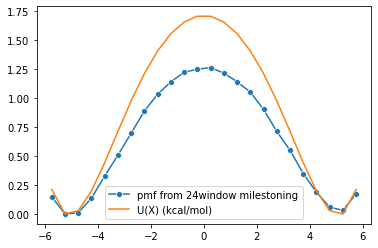

In [124]:
piVec=testEscapeData['piVec']
#sns.lineplot(np.arange(len(piVec)),piVec, marker='o', color='g', label="piVec")
pmfVec=-kbT*np.log(testEscapeData['piVec'])
print("pmf", pmfVec)
pmfVec=pmfVec-np.min(pmfVec)
xgrid=symm_window_centers
print("window center",xgrid)
sns.lineplot(
    x=xgrid,
    y=pmfVec, marker='o',label="pmf from 24window milestoning")

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)

plt.show()

In [358]:
np.savetxt('escapeMat.txt',testEscapeData['escapeMat'].todense())
escapeMat=np.loadtxt('escapeMat.txt')
print(escapeMat)
print(escapeMat.sum(axis=1))

nzInds=np.nonzero(escapeMat)
print(nzInds)
waitMat=1./escapeMat
waitTable=pd.DataFrame({'window':nzInds[0],'escapeCell':nzInds[1],'meanWaitTime':waitMat[nzInds]})
notselfwaitTable=waitTable.query("window!=escapeCell")
print( notselfwaitTable) # waitTime should make sense when comparing with pmf above

[[0.95920218 0.04079782 0.         0.        ]
 [0.29079679 0.6291538  0.08004941 0.        ]
 [0.         0.0786625  0.62905942 0.29227809]
 [0.         0.         0.04367211 0.95632789]]
[1. 1. 1. 1.]
(array([0, 0, 1, 1, 1, 2, 2, 2, 3, 3]), array([0, 1, 0, 1, 2, 1, 2, 3, 2, 3]))
   window  escapeCell  meanWaitTime
1       0           1     24.511111
2       1           0      3.438828
4       1           2     12.492284
5       2           1     12.712538
7       2           3      3.421399
8       3           2     22.897909


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [361]:
np.savetxt('countsMat.txt',testEscapeData['countsMat'].todense())
countsMat=np.loadtxt('countsMat.txt')
print(countsMat)  # countsMat is Cii (frames in cell i) and Cij (transition event from i to j), Kij=Cij/Cii
print(countsMat.sum(axis=1))


[[18751.   765.     0.     0.]
 [ 2354.  8095.   648.     0.]
 [    0.   654.  8314.  2430.]
 [    0.     0.   813. 18616.]]
[19516. 11097. 11398. 19429.]
